In [1899]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler





In [1900]:
random_state=42

# Cruide Oil WTI 

## 7:3

In [1901]:
df= pd.read_csv('../dataset/Crude Oil WTI.csv')
df = df.dropna() # Drop missing values


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [1902]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [1903]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,55.8,57.22,57.88,55.57,684190,-2.48
1,2019-03-02 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
2,2019-03-03 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
3,2019-03-04 00:00:00,56.59,55.83,57.0,55.81,549400,1.42
4,2019-03-05 00:00:00,56.56,56.45,57.19,56.09,538400,-0.05
...,...,...,...,...,...,...,...
1914,2024-05-27 00:00:00,78.775,77.425,79.17,76.92,316575.0,1.305
1915,2024-05-28 00:00:00,79.83,77.81,80.29,77.69,334070,1.5
1916,2024-05-29 00:00:00,79.23,80.26,80.62,78.99,259589,-0.75
1917,2024-05-30 00:00:00,77.91,79.28,79.42,77.63,373780,-1.67


### Tạo hàm Eval

In [1904]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [1905]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,55.8
1,56.195
2,56.195
3,56.59
4,56.56
...,...
1914,78.775
1915,79.83
1916,79.23
1917,77.91


### Train, Test


In [1906]:
# Split the data into training, testing
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [1907]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [1908]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [1909]:
eval(y_test,y_pred)

** Testing **
MAE:  25.9075459148466
MAPE:  33.693462620659425
RMSE:  27.198485863071795


### Predict

In [1910]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [1911]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[116.0427594  116.08406836 116.12537732 116.16668628 116.20799524
 116.2493042  116.29061316 116.33192212 116.37323108 116.41454004
 116.455849   116.49715796 116.53846692 116.57977588 116.62108484
 116.6623938  116.70370276 116.74501172 116.78632068 116.82762964
 116.8689386  116.91024756 116.95155652 116.99286548 117.03417444
 117.0754834  117.11679236 117.15810132 117.19941028 117.24071924]
Predicted closing prices for the next 60 days:
[117.2820282  117.32333716 117.36464612 117.40595508 117.44726404
 117.488573   117.52988196 117.57119092 117.61249988 117.65380884
 117.6951178  117.73642676 117.77773572 117.81904468 117.86035364
 117.9016626  117.94297156 117.98428052 118.02558948 118.06689844
 118.1082074  118.14951636 118.19082532 118.23213428 118.27344324
 118.3147522  118.35606116 118.39737012 118.43867908 118.47998804]
Predicted closing prices for the next 90 days:
[118.521297   118.56260596 118.60391492 118.64522388 118.68653284

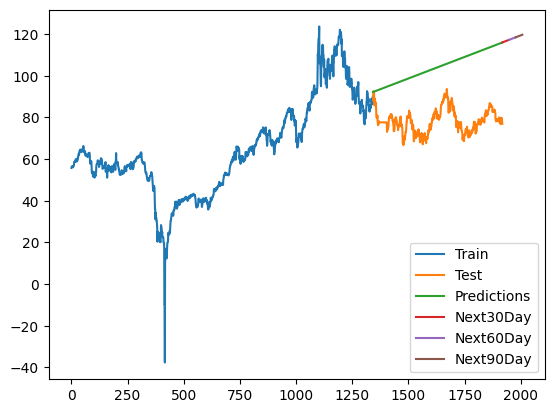

In [1912]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Gasoline RBOB

## 7:3

In [1913]:
df= pd.read_csv('../dataset/Gasoline RBOB.csv')
df = df.dropna() # Drop missing values


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [1914]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [1915]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,1.5356,1.7521,1.772,1.7124,69010,-1.37
1,2019-03-02 00:00:00,1.5443,1.7403,1.769,1.72045,65780.0,-5.89
2,2019-03-03 00:00:00,1.5443,1.7403,1.769,1.72045,65780.0,-5.89
3,2019-03-04 00:00:00,1.553,1.7285,1.766,1.7285,62550,-10.41
4,2019-03-05 00:00:00,1.5601,1.7474,1.7735,1.7387,61430,0.46
...,...,...,...,...,...,...,...
1914,2024-05-27 00:00:00,2.514,2.502,2.5154,2.502,20,1.53
1915,2024-05-28 00:00:00,2.509,2.5151,2.5244,2.5022,330,-0.2
1916,2024-05-29 00:00:00,2.4644,2.5208,2.5304,2.4579,1280,-1.78
1917,2024-05-30 00:00:00,2.4046,2.456,2.4613,2.4295,440,-2.43


### Tạo hàm Eval

In [1916]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [1917]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,1.5356
1,1.5443
2,1.5443
3,1.553
4,1.5601
...,...
1914,2.514
1915,2.509
1916,2.4644
1917,2.4046


### Train, Test


In [1918]:
# Split the data into training, testing sets
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [1919]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [1920]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [1921]:
eval(y_test,y_pred)

** Testing **
MAE:  0.2873271869308125
MAPE:  12.316846819610776
RMSE:  0.36969567629406297


### Predict

In [1922]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [1923]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[3.01276855 3.01381034 3.01485212 3.01589391 3.01693569 3.01797748
 3.01901926 3.02006104 3.02110283 3.02214461 3.0231864  3.02422818
 3.02526997 3.02631175 3.02735354 3.02839532 3.0294371  3.03047889
 3.03152067 3.03256246 3.03360424 3.03464603 3.03568781 3.0367296
 3.03777138 3.03881316 3.03985495 3.04089673 3.04193852 3.0429803 ]
Predicted closing prices for the next 60 days:
[3.04402209 3.04506387 3.04610566 3.04714744 3.04818922 3.04923101
 3.05027279 3.05131458 3.05235636 3.05339815 3.05443993 3.05548172
 3.0565235  3.05756528 3.05860707 3.05964885 3.06069064 3.06173242
 3.06277421 3.06381599 3.06485778 3.06589956 3.06694134 3.06798313
 3.06902491 3.0700667  3.07110848 3.07215027 3.07319205 3.07423384]
Predicted closing prices for the next 90 days:
[3.07527562 3.0763174  3.07735919 3.07840097 3.07944276 3.08048454
 3.08152633 3.08256811 3.0836099  3.08465168 3.08569346 3.08673525
 3.08777703 3.08881882 3.0898606  3.09090239 3.0919441

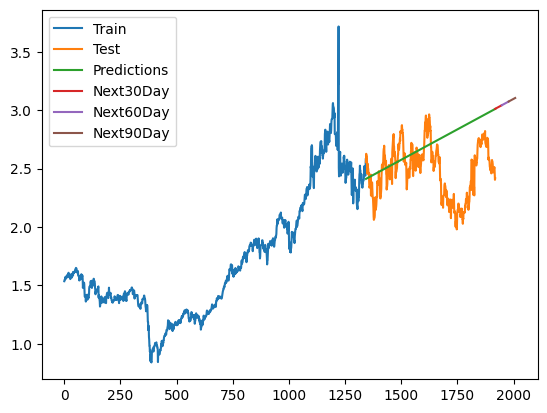

In [1924]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Heating Oil

## 7:3

In [1925]:
df= pd.read_csv('../dataset/Heating Oil.csv')
df = df.dropna() # Drop missing values


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [1926]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [1927]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160,0.1
...,...,...,...,...,...,...,...
1914,2024-05-27 00:00:00,2.4393,2.41615,2.4551,2.4014,25415.0,0.32
1915,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960,0.57
1916,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870,-1.14
1917,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120,-2.77


### Tạo hàm Eval

In [1928]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [1929]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,2.001
1,2.00765
2,2.00765
3,2.0143
4,2.0164
...,...
1914,2.4393
1915,2.465
1916,2.437
1917,2.3694


### Train, Test


In [1930]:
# Split the data into training, testing sets
train_size = int(0.7 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [1931]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [1932]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [1933]:
eval(y_test,y_pred)

** Testing **
MAE:  0.9145009169376278
MAPE:  34.37215411232412
RMSE:  1.0169420216377005


### Predict

In [1934]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [1935]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[4.1624304  4.16403539 4.16564038 4.16724537 4.16885036 4.17045535
 4.17206034 4.17366533 4.17527032 4.17687531 4.1784803  4.18008529
 4.18169028 4.18329527 4.18490025 4.18650524 4.18811023 4.18971522
 4.19132021 4.1929252  4.19453019 4.19613518 4.19774017 4.19934516
 4.20095015 4.20255514 4.20416013 4.20576512 4.20737011 4.2089751 ]
Predicted closing prices for the next 60 days:
[4.21058009 4.21218508 4.21379007 4.21539506 4.21700005 4.21860504
 4.22021003 4.22181502 4.22342001 4.225025   4.22662999 4.22823498
 4.22983997 4.23144495 4.23304994 4.23465493 4.23625992 4.23786491
 4.2394699  4.24107489 4.24267988 4.24428487 4.24588986 4.24749485
 4.24909984 4.25070483 4.25230982 4.25391481 4.2555198  4.25712479]
Predicted closing prices for the next 90 days:
[4.25872978 4.26033477 4.26193976 4.26354475 4.26514974 4.26675473
 4.26835972 4.26996471 4.2715697  4.27317469 4.27477968 4.27638466
 4.27798965 4.27959464 4.28119963 4.28280462 4.284409

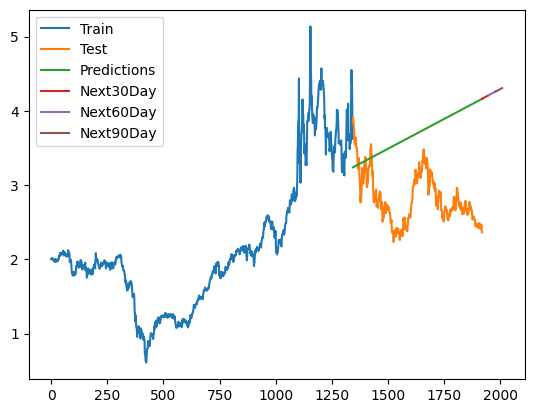

In [1936]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Cruide Oil WTI 

## 8:2

In [1937]:
df= pd.read_csv('../dataset/Crude Oil WTI.csv')
df = df.dropna() # Drop missing values


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [1938]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [1939]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,55.8,57.22,57.88,55.57,684190,-2.48
1,2019-03-02 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
2,2019-03-03 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
3,2019-03-04 00:00:00,56.59,55.83,57.0,55.81,549400,1.42
4,2019-03-05 00:00:00,56.56,56.45,57.19,56.09,538400,-0.05
...,...,...,...,...,...,...,...
1914,2024-05-27 00:00:00,78.775,77.425,79.17,76.92,316575.0,1.305
1915,2024-05-28 00:00:00,79.83,77.81,80.29,77.69,334070,1.5
1916,2024-05-29 00:00:00,79.23,80.26,80.62,78.99,259589,-0.75
1917,2024-05-30 00:00:00,77.91,79.28,79.42,77.63,373780,-1.67


### Tạo hàm Eval

In [1940]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [1941]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,55.8
1,56.195
2,56.195
3,56.59
4,56.56
...,...
1914,78.775
1915,79.83
1916,79.23
1917,77.91


### Train, Test


In [1942]:
# Split the data into training, testing sets
train_size = int(0.8 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [1943]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [1944]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [1945]:
eval(y_test,y_pred)

** Testing **
MAE:  19.53162241521234
MAPE:  25.48395372860624
RMSE:  20.489423186710752


### Predict

In [1946]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [1947]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[104.41578384 104.44901014 104.48223643 104.51546273 104.54868903
 104.58191533 104.61514163 104.64836793 104.68159423 104.71482052
 104.74804682 104.78127312 104.81449942 104.84772572 104.88095202
 104.91417832 104.94740461 104.98063091 105.01385721 105.04708351
 105.08030981 105.11353611 105.14676241 105.1799887  105.213215
 105.2464413  105.2796676  105.3128939  105.3461202  105.37934649]
Predicted closing prices for the next 60 days:
[105.41257279 105.44579909 105.47902539 105.51225169 105.54547799
 105.57870429 105.61193058 105.64515688 105.67838318 105.71160948
 105.74483578 105.77806208 105.81128838 105.84451467 105.87774097
 105.91096727 105.94419357 105.97741987 106.01064617 106.04387247
 106.07709876 106.11032506 106.14355136 106.17677766 106.21000396
 106.24323026 106.27645655 106.30968285 106.34290915 106.37613545]
Predicted closing prices for the next 90 days:
[106.40936175 106.44258805 106.47581435 106.50904064 106.54226694
 

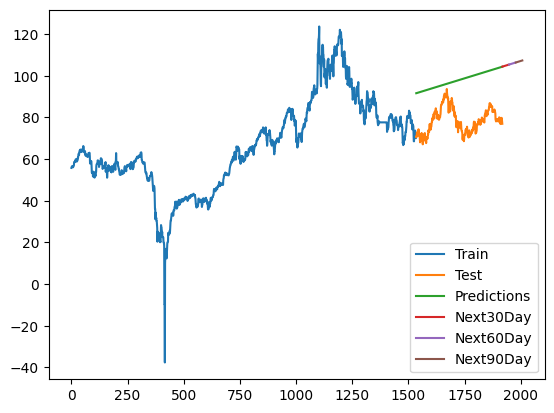

In [1948]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Gasoline RBOB

## 8:2

In [1949]:
df= pd.read_csv('../dataset/Gasoline RBOB.csv')
df = df.dropna() # Drop missing values


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [1950]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [1951]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,1.5356,1.7521,1.772,1.7124,69010,-1.37
1,2019-03-02 00:00:00,1.5443,1.7403,1.769,1.72045,65780.0,-5.89
2,2019-03-03 00:00:00,1.5443,1.7403,1.769,1.72045,65780.0,-5.89
3,2019-03-04 00:00:00,1.553,1.7285,1.766,1.7285,62550,-10.41
4,2019-03-05 00:00:00,1.5601,1.7474,1.7735,1.7387,61430,0.46
...,...,...,...,...,...,...,...
1914,2024-05-27 00:00:00,2.514,2.502,2.5154,2.502,20,1.53
1915,2024-05-28 00:00:00,2.509,2.5151,2.5244,2.5022,330,-0.2
1916,2024-05-29 00:00:00,2.4644,2.5208,2.5304,2.4579,1280,-1.78
1917,2024-05-30 00:00:00,2.4046,2.456,2.4613,2.4295,440,-2.43


### Tạo hàm Eval

In [1952]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [1953]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,1.5356
1,1.5443
2,1.5443
3,1.553
4,1.5601
...,...
1914,2.514
1915,2.509
1916,2.4644
1917,2.4046


### Train, Test


In [1954]:
# Split the data into training, testing sets
train_size = int(0.8 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [1955]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [1956]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [1957]:
eval(y_test,y_pred)

** Testing **
MAE:  0.35716365423126967
MAPE:  15.431873218523116
RMSE:  0.42943250967426705


### Predict

In [1958]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [1959]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[2.99914985 3.0001825  3.00121515 3.0022478  3.00328045 3.0043131
 3.00534575 3.0063784  3.00741105 3.0084437  3.00947635 3.010509
 3.01154165 3.0125743  3.01360695 3.0146396  3.01567225 3.0167049
 3.01773755 3.0187702  3.01980285 3.0208355  3.02186815 3.0229008
 3.02393345 3.0249661  3.02599875 3.0270314  3.02806405 3.0290967 ]
Predicted closing prices for the next 60 days:
[3.03012935 3.031162   3.03219465 3.03322729 3.03425994 3.03529259
 3.03632524 3.03735789 3.03839054 3.03942319 3.04045584 3.04148849
 3.04252114 3.04355379 3.04458644 3.04561909 3.04665174 3.04768439
 3.04871704 3.04974969 3.05078234 3.05181499 3.05284764 3.05388029
 3.05491294 3.05594559 3.05697824 3.05801089 3.05904354 3.06007619]
Predicted closing prices for the next 90 days:
[3.06110884 3.06214149 3.06317414 3.06420679 3.06523944 3.06627209
 3.06730474 3.06833739 3.06937004 3.07040269 3.07143534 3.07246799
 3.07350064 3.07453329 3.07556594 3.07659859 3.07763124 3.

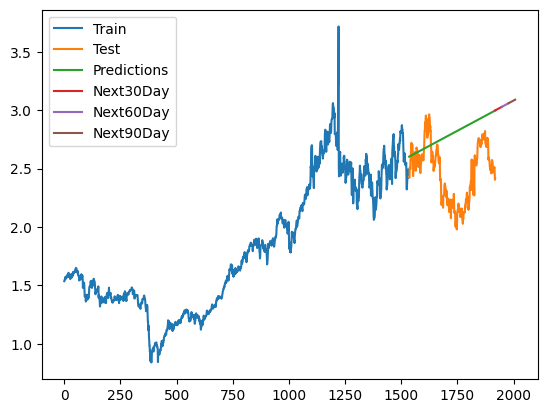

In [1960]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Heating Oil

## 8:2

In [1961]:
df= pd.read_csv('../dataset/Heating Oil.csv')
df = df.dropna() # Drop missing values


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [1962]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [1963]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160,0.1
...,...,...,...,...,...,...,...
1914,2024-05-27 00:00:00,2.4393,2.41615,2.4551,2.4014,25415.0,0.32
1915,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960,0.57
1916,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870,-1.14
1917,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120,-2.77


### Tạo hàm Eval

In [1964]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [1965]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,2.001
1,2.00765
2,2.00765
3,2.0143
4,2.0164
...,...
1914,2.4393
1915,2.465
1916,2.437
1917,2.3694


### Train, Test


In [1966]:
# Split the data into training, testing sets
train_size = int(0.8 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [1967]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [1968]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [1969]:
eval(y_test,y_pred)

** Testing **
MAE:  0.8516468325972587
MAPE:  32.352976739473334
RMSE:  0.917473187123455


### Predict

In [1970]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [1971]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[3.87030099 3.87170068 3.87310037 3.87450007 3.87589976 3.87729945
 3.87869914 3.88009883 3.88149852 3.88289821 3.8842979  3.88569759
 3.88709728 3.88849697 3.88989667 3.89129636 3.89269605 3.89409574
 3.89549543 3.89689512 3.89829481 3.8996945  3.90109419 3.90249388
 3.90389357 3.90529326 3.90669296 3.90809265 3.90949234 3.91089203]
Predicted closing prices for the next 60 days:
[3.91229172 3.91369141 3.9150911  3.91649079 3.91789048 3.91929017
 3.92068986 3.92208955 3.92348925 3.92488894 3.92628863 3.92768832
 3.92908801 3.9304877  3.93188739 3.93328708 3.93468677 3.93608646
 3.93748615 3.93888584 3.94028554 3.94168523 3.94308492 3.94448461
 3.9458843  3.94728399 3.94868368 3.95008337 3.95148306 3.95288275]
Predicted closing prices for the next 90 days:
[3.95428244 3.95568214 3.95708183 3.95848152 3.95988121 3.9612809
 3.96268059 3.96408028 3.96547997 3.96687966 3.96827935 3.96967904
 3.97107873 3.97247843 3.97387812 3.97527781 3.9766775

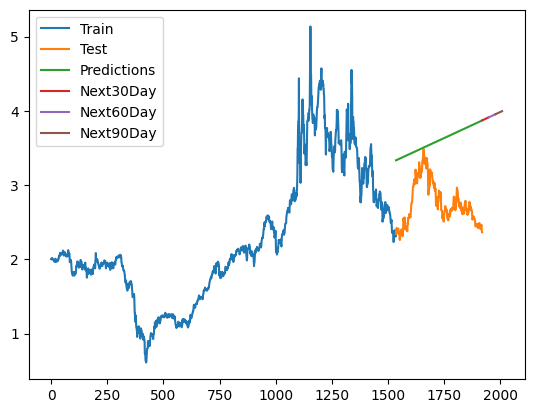

In [1972]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Cruide Oil WTI 

## 9:1

In [1973]:
df= pd.read_csv('../dataset/Crude Oil WTI.csv')
df = df.dropna() # Drop missing values


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [1974]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [1975]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,55.8,57.22,57.88,55.57,684190,-2.48
1,2019-03-02 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
2,2019-03-03 00:00:00,56.195,56.525,57.44,55.69,616795.0,-0.53
3,2019-03-04 00:00:00,56.59,55.83,57.0,55.81,549400,1.42
4,2019-03-05 00:00:00,56.56,56.45,57.19,56.09,538400,-0.05
...,...,...,...,...,...,...,...
1914,2024-05-27 00:00:00,78.775,77.425,79.17,76.92,316575.0,1.305
1915,2024-05-28 00:00:00,79.83,77.81,80.29,77.69,334070,1.5
1916,2024-05-29 00:00:00,79.23,80.26,80.62,78.99,259589,-0.75
1917,2024-05-30 00:00:00,77.91,79.28,79.42,77.63,373780,-1.67


### Tạo hàm Eval

In [1976]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [1977]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,55.8
1,56.195
2,56.195
3,56.59
4,56.56
...,...
1914,78.775
1915,79.83
1916,79.23
1917,77.91


### Train, Test


In [1978]:
# Split the data into training, testing sets
train_size = int(0.9 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [1979]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [1980]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [1981]:
eval(y_test,y_pred)

** Testing **
MAE:  16.807051776640353
MAPE:  21.94855230236308
RMSE:  17.149514759325495


### Predict

In [1982]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [1983]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[97.1519572  97.17993657 97.20791595 97.23589532 97.2638747  97.29185407
 97.31983344 97.34781282 97.37579219 97.40377157 97.43175094 97.45973031
 97.48770969 97.51568906 97.54366843 97.57164781 97.59962718 97.62760656
 97.65558593 97.6835653  97.71154468 97.73952405 97.76750343 97.7954828
 97.82346217 97.85144155 97.87942092 97.9074003  97.93537967 97.96335904]
Predicted closing prices for the next 60 days:
[97.99133842 98.01931779 98.04729717 98.07527654 98.10325591 98.13123529
 98.15921466 98.18719404 98.21517341 98.24315278 98.27113216 98.29911153
 98.32709091 98.35507028 98.38304965 98.41102903 98.4390084  98.46698778
 98.49496715 98.52294652 98.5509259  98.57890527 98.60688465 98.63486402
 98.66284339 98.69082277 98.71880214 98.74678152 98.77476089 98.80274026]
Predicted closing prices for the next 90 days:
[98.83071964 98.85869901 98.88667839 98.91465776 98.94263713 98.97061651
 98.99859588 99.02657526 99.05455463 99.082534   99.110

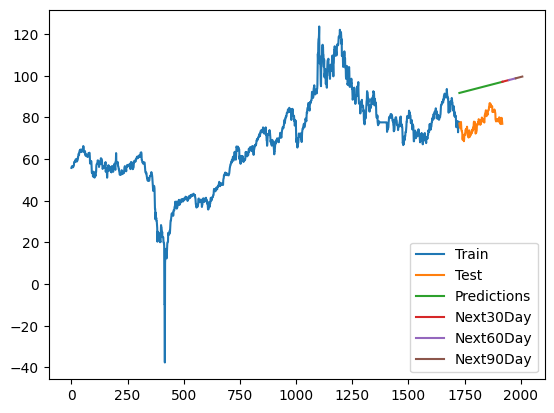

In [1984]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Gasoline RBOB

## 9:1

In [1985]:
df= pd.read_csv('../dataset/Gasoline RBOB.csv')
df = df.dropna() # Drop missing values


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [1986]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [1987]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,1.5356,1.7521,1.772,1.7124,69010,-1.37
1,2019-03-02 00:00:00,1.5443,1.7403,1.769,1.72045,65780.0,-5.89
2,2019-03-03 00:00:00,1.5443,1.7403,1.769,1.72045,65780.0,-5.89
3,2019-03-04 00:00:00,1.553,1.7285,1.766,1.7285,62550,-10.41
4,2019-03-05 00:00:00,1.5601,1.7474,1.7735,1.7387,61430,0.46
...,...,...,...,...,...,...,...
1914,2024-05-27 00:00:00,2.514,2.502,2.5154,2.502,20,1.53
1915,2024-05-28 00:00:00,2.509,2.5151,2.5244,2.5022,330,-0.2
1916,2024-05-29 00:00:00,2.4644,2.5208,2.5304,2.4579,1280,-1.78
1917,2024-05-30 00:00:00,2.4046,2.456,2.4613,2.4295,440,-2.43


### Tạo hàm Eval

In [1988]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [1989]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,1.5356
1,1.5443
2,1.5443
3,1.553
4,1.5601
...,...
1914,2.514
1915,2.509
1916,2.4644
1917,2.4046


### Train, Test


In [1990]:
# Split the data into training, testing sets
train_size = int(0.9 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [1991]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [1992]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [1993]:
eval(y_test,y_pred)

** Testing **
MAE:  0.40378827504233544
MAPE:  17.805606381441308
RMSE:  0.4559153367917391


### Predict

In [1994]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [1995]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[2.91400946 2.91497935 2.91594924 2.91691913 2.91788902 2.91885891
 2.9198288  2.92079869 2.92176858 2.92273847 2.92370836 2.92467825
 2.92564814 2.92661803 2.92758792 2.92855781 2.9295277  2.93049759
 2.93146748 2.93243737 2.93340726 2.93437715 2.93534704 2.93631693
 2.93728682 2.93825671 2.9392266  2.94019649 2.94116638 2.94213627]
Predicted closing prices for the next 60 days:
[2.94310616 2.94407605 2.94504594 2.94601583 2.94698572 2.9479556
 2.94892549 2.94989538 2.95086527 2.95183516 2.95280505 2.95377494
 2.95474483 2.95571472 2.95668461 2.9576545  2.95862439 2.95959428
 2.96056417 2.96153406 2.96250395 2.96347384 2.96444373 2.96541362
 2.96638351 2.9673534  2.96832329 2.96929318 2.97026307 2.97123296]
Predicted closing prices for the next 90 days:
[2.97220285 2.97317274 2.97414263 2.97511252 2.97608241 2.9770523
 2.97802219 2.97899208 2.97996197 2.98093186 2.98190175 2.98287164
 2.98384153 2.98481142 2.98578131 2.9867512  2.98772109

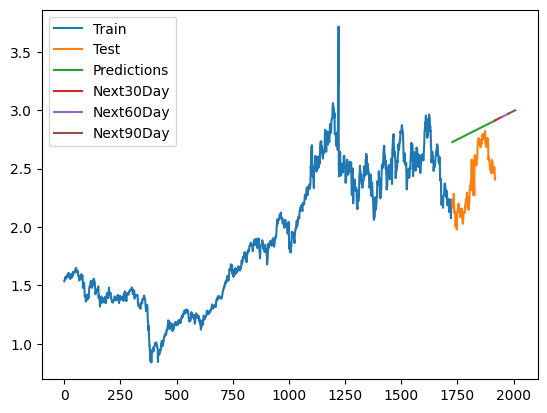

In [1996]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()

# Heating Oil

## 9:1

In [1997]:
df= pd.read_csv('../dataset/Heating Oil.csv')
df = df.dropna() # Drop missing values


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [1998]:

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)



In [1999]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160,0.1
...,...,...,...,...,...,...,...
1914,2024-05-27 00:00:00,2.4393,2.41615,2.4551,2.4014,25415.0,0.32
1915,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960,0.57
1916,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870,-1.14
1917,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120,-2.77


### Tạo hàm Eval

In [2000]:
def eval(test,pred):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)



In [2001]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Price
0,2.001
1,2.00765
2,2.00765
3,2.0143
4,2.0164
...,...
1914,2.4393
1915,2.465
1916,2.437
1917,2.3694


### Train, Test


In [2002]:
# Split the data into training, testing sets
train_size = int(0.9 * len(df))
test_size = len(df)-train_size
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

### Tạo và huấn luyện mô hình

In [2003]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [2004]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(x_test)


### Eval

In [2005]:
eval(y_test,y_pred)

** Testing **
MAE:  0.8228084971304837
MAPE:  31.469436703448476
RMSE:  0.8406282031629135


### Predict

In [2006]:
last_index =  df.index[-1]
last_data_30_days = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
y_next_30_days = model.predict(x_next_30_days)
last_data_60_days = pd.RangeIndex(start=last_index+30, stop=last_index+60, step=1)
x_next_60_days = np.array(range(last_index+31, last_index+61)).reshape(-1, 1)
y_next_60_days = model.predict(x_next_60_days)
last_data_90_days = pd.RangeIndex(start=last_index+60, stop=last_index+90, step=1)
x_next_90_days = np.array(range(last_index+61, last_index+91)).reshape(-1, 1)
y_next_90_days = model.predict(x_next_90_days)

In [2007]:
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days)
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)
     

Predicted closing prices for the next 30 days:
[3.58384781 3.58504087 3.58623394 3.58742701 3.58862008 3.58981314
 3.59100621 3.59219928 3.59339234 3.59458541 3.59577848 3.59697155
 3.59816461 3.59935768 3.60055075 3.60174381 3.60293688 3.60412995
 3.60532302 3.60651608 3.60770915 3.60890222 3.61009528 3.61128835
 3.61248142 3.61367448 3.61486755 3.61606062 3.61725369 3.61844675]
Predicted closing prices for the next 60 days:
[3.61963982 3.62083289 3.62202595 3.62321902 3.62441209 3.62560516
 3.62679822 3.62799129 3.62918436 3.63037742 3.63157049 3.63276356
 3.63395663 3.63514969 3.63634276 3.63753583 3.63872889 3.63992196
 3.64111503 3.6423081  3.64350116 3.64469423 3.6458873  3.64708036
 3.64827343 3.6494665  3.65065957 3.65185263 3.6530457  3.65423877]
Predicted closing prices for the next 90 days:
[3.65543183 3.6566249  3.65781797 3.65901104 3.6602041  3.66139717
 3.66259024 3.6637833  3.66497637 3.66616944 3.6673625  3.66855557
 3.66974864 3.67094171 3.67213477 3.67332784 3.674520

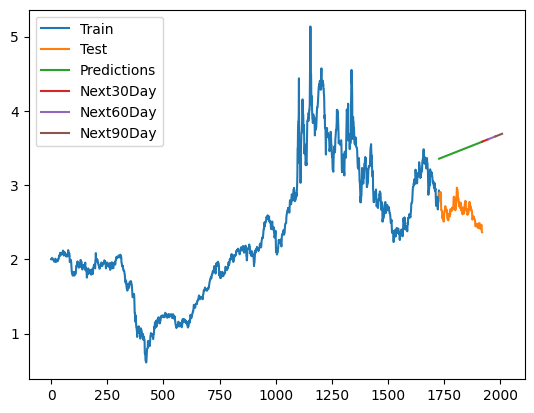

In [2008]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data_30_days,y_next_30_days)
plt.plot(last_data_60_days,y_next_60_days)
plt.plot(last_data_90_days,y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()